<a href="https://colab.research.google.com/github/yong2691/DataScience/blob/main/Deep%20Learning/Samsung_StockPrice_Predict/%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90_%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LSTM과 FinanceDataReader API를 활용한 삼성전자 주가 예측
이번 튜토리얼에서는 딥러닝 모델을 활용하여 삼성전자 주가 예측을 진행해 보겠습니다.

이전에도 한 번 공유해 드린 적이 있고, 다시 내용을 작성하는 이유는 이번에는 FinanceDataReader 파이썬 패키지를 활용하여 진행해볼 예정입니다.

FinanceDataReader를 활용하면 더이상 파일데이터로 주가 데이터를 수집해올 필요가 없으며, 가장 최신의 업데이트된 데이터를 API 콜을 통해 DataFrame으로 받아올 수 있습니다.

또한 TensorFlow에서 윈도우 데이터셋으로 구성하여 코드가 보다 간결해 졌습니다.

이전 블로그 글과 비교해보실 분들은 아래 링크를 참고해 주세요.

#LSTM을 활용한 주가 예측 모델


이번 튜토리얼 에서는 다음과 같은 프로세스 파이프라인으로 주가 예측을 진행합니다.

- FinanceDataReader를 활용하여 주가 데이터 받아오기
- TensorFlow Dataset 클래스를 활용하여 주가 데이터 구축
- LSTM 을 활용한 주가 예측 모델 구축

#필요한 모듈 import


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

#데이터 (FinanceDataReader)


FinanceDataReader는 주가 데이터를 편리하게 가져올 수 있는 파이썬 패키지입니다.

[github](https://github.com/FinanceData/FinanceDataReader)

* 마크다운에서 하이퍼링크를 걸고 싶으면?      [하이퍼링크이름]    (주소명)

FinanceDataReader가 아직 설치 되지 않으신 분들은 아래의 주석을 해제한 후 명령어로 설치해 주시기 바랍니다.



In [9]:
!pip install finance-datareader
import FinanceDataReader as fdr


In [10]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

매우 편리하게 삼성전자 주가 데이터를 DataFrame형식으로 받아옵니다.

기본 오름차순 정렬이 된 데이터임을 알 수 있습니다.

컬럼 설명
Open: 시가
High: 고가
Low: 저가
Close: 종가
Volume: 거래량
Change: 대비

In [11]:
samsung.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-07-12,79900,80000,79500,79700,9768108,0.003778
2021-07-13,80000,80200,79800,79800,9863450,0.001255
2021-07-14,79400,79600,79100,79500,11575636,-0.003759
2021-07-15,79800,80600,79500,80600,13766279,0.013836
2021-07-16,80100,80100,79500,79800,10777389,-0.009926


미국 주식 데이터도 가져올 수 있습니다.



In [13]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL')

In [14]:
apple.tail()


,Close,Open,High,Low,Volume,Change
Date,,,,,,
2021-07-09,145.11,142.75,145.65,142.65,99890000.0,0.0131
2021-07-12,144.50,146.22,146.22,144.04,76300000.0,-0.0042
2021-07-13,145.64,143.70,147.46,143.70,100830000.0,0.0079
2021-07-14,149.15,148.00,149.57,147.70,127050000.0,0.0241
2021-07-15,148.48,149.25,149.98,147.10,106820000.0,-0.0045


다음과 같이 2017을 같이 넘겨주면, 해당 시점 이후의 주식 데이터를 가져옵니다.

In [15]:
# Apple(AAPL), 애플
apple = fdr.DataReader('AAPL', '2017')

In [16]:
apple.head()


,Close,Open,High,Low,Volume,Change
Date,,,,,,
2017-01-03,29.04,28.95,29.08,28.69,115130000.0,0.0031
2017-01-04,29.00,28.96,29.13,28.94,84470000.0,-0.0014
2017-01-05,29.15,28.98,29.22,28.95,88770000.0,0.0052
2017-01-06,29.48,29.20,29.54,29.12,127010000.0,0.0113
2017-01-09,29.75,29.49,29.86,29.48,134250000.0,0.0092


시작과 끝 날짜를 지정하여 범위 데이터를 가져올 수 있습니다.



In [17]:
# Ford(F), 1980-01-01 ~ 2019-12-30 (40년 데이터)
ford = fdr.DataReader('F', '1980-01-01', '2019-12-30')

In [18]:
ford.head()


,Close,Open,High,Low,Volume,Change
Date,,,,,,
1980-03-18,1.83,1.83,1.85,1.82,3770000.0,-0.0108
1980-03-19,1.85,1.85,1.86,1.83,1560000.0,0.0109
1980-03-20,1.86,1.86,1.88,1.85,1450000.0,0.0054
1980-03-21,1.78,1.78,1.85,1.76,5020000.0,-0.0430
1980-03-24,1.71,1.71,1.75,1.66,3330000.0,-0.0393


In [19]:
ford.tail()


,Close,Open,High,Low,Volume,Change
Date,,,,,,
2019-12-23,9.44,9.50,9.57,9.40,54800000.0,-0.0042
2019-12-24,9.47,9.44,9.49,9.43,11880000.0,0.0032
2019-12-26,9.45,9.47,9.49,9.43,28980000.0,-0.0021
2019-12-27,9.36,9.45,9.46,9.35,28270000.0,-0.0095
2019-12-30,9.25,9.34,9.35,9.23,36090000.0,-0.0118


그 밖에 금, 은과 같은 현물, 달러와 같은 화폐 데이터도 가져올 수 있습니다.

더욱 자세한 내용은 GitHub 페이지 링크를 참고해 보시기 바랍니다.

#주가데이터 가져오기


지난 주식 예측 튜토리얼에서는 삼성전자 주가데이터로 실습을 해봤으니,

이번에는 글로벌 증시의 대장주인 Apple사의 주가데이터를 가져와서 예측해 보도록 하겠습니다

In [20]:
# 삼성전자 주식코드: 005930
STOCK_CODE = '005930'

In [21]:
stock = fdr.DataReader(STOCK_CODE)


In [22]:
stock.head()


,Open,High,Low,Close,Volume,Change
Date,,,,,,
1997-07-09,1238,1247,1217,1240,53680,NaN
1997-07-10,1242,1243,1220,1233,115250,-0.005645
1997-07-11,1227,1233,1209,1215,37380,-0.014599
1997-07-12,1206,1215,1202,1208,41660,-0.005761
1997-07-14,1200,1217,1190,1208,131010,0.000000


In [23]:
stock.tail()


,Open,High,Low,Close,Volume,Change
Date,,,,,,
2021-07-12,79900,80000,79500,79700,9768108,0.003778
2021-07-13,80000,80200,79800,79800,9863450,0.001255
2021-07-14,79400,79600,79100,79500,11575636,-0.003759
2021-07-15,79800,80600,79500,80600,13766279,0.013836
2021-07-16,80100,80100,79500,79800,10780961,-0.009926


In [24]:
stock.index


DatetimeIndex(['1997-07-09', '1997-07-10', '1997-07-11', '1997-07-12',
               '1997-07-14', '1997-07-15', '1997-07-16', '1997-07-18',
               '1997-07-19', '1997-07-21',
               ...
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-12', '2021-07-13', '2021-07-14',
               '2021-07-15', '2021-07-16'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

위에서 보시는 바와 같이 index가 DatetimeIndex로 지정되어 있습니다.

DatetimeIndex로 정의되어 있다면, 아래와 같이 연도, 월, 일을 쪼갤 수 있으며, 월별, 연도별 피벗데이터를 만들때 유용하게 활용할 수 있습니다.

In [25]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

In [26]:
stock.head()


,Open,High,Low,Close,Volume,Change,Year,Month,Day
Date,,,,,,,,,
1997-07-09,1238,1247,1217,1240,53680,NaN,1997,7,9
1997-07-10,1242,1243,1220,1233,115250,-0.005645,1997,7,10
1997-07-11,1227,1233,1209,1215,37380,-0.014599,1997,7,11
1997-07-12,1206,1215,1202,1208,41660,-0.005761,1997,7,12
1997-07-14,1200,1217,1190,1208,131010,0.000000,1997,7,14


#시각화


Text(0, 0.5, 'price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


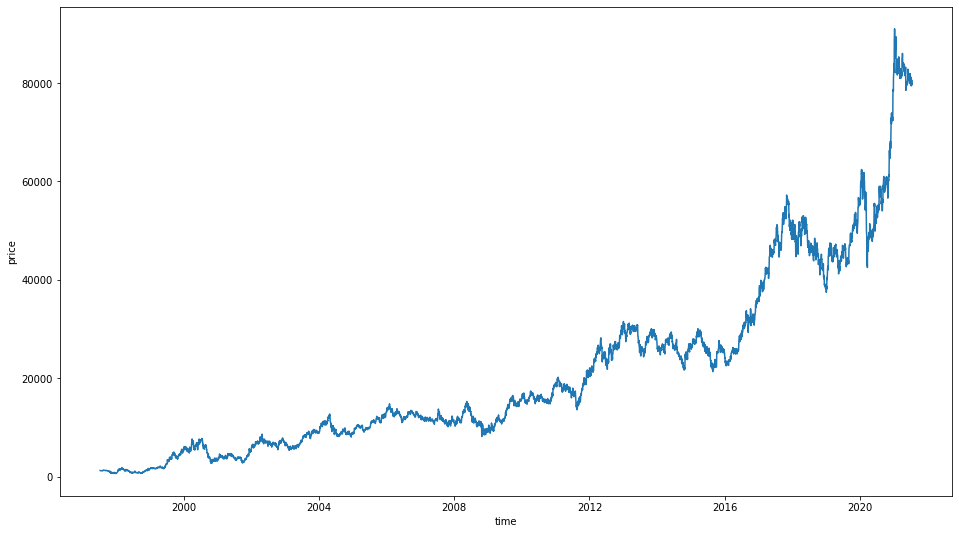

In [27]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


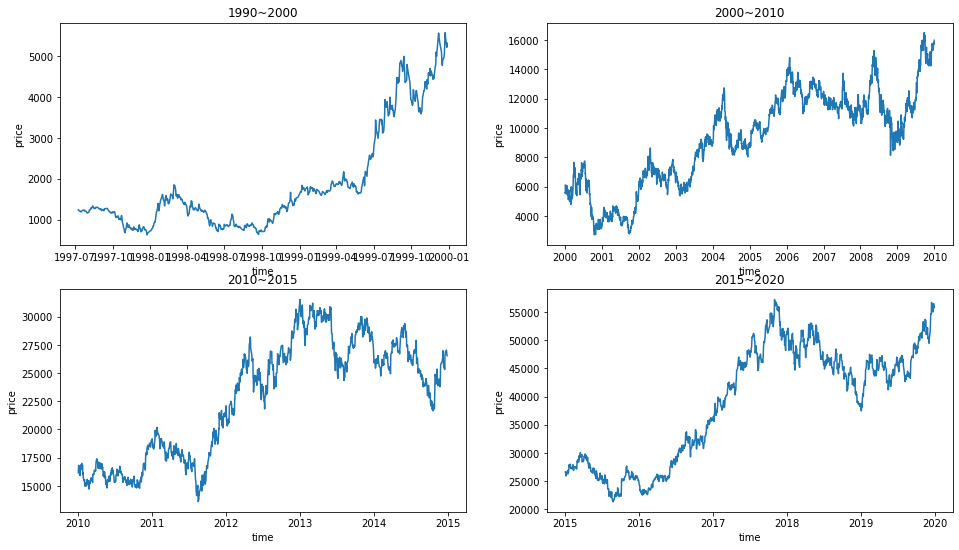

In [28]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y=df['Close'], x=df.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
    plt.tight_layout()
plt.show()

#데이터 전처리


주가 데이터에 대하여 딥러닝 모델이 더 잘 학습할 수 있도록 정규화(Normalization)를 해주도록 하겠습니다.

표준화 (Standardization)와 정규화(Normalization)에 대한 내용은 아래 링크에서 더 자세히 다루니, 참고해 보시기 바랍니다.

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # MinMaxScaler()는 0~1사이의 값으로 변환 #standarscaler는 -1 ~ +1로 변환
# 스케일을 적용할 column을 정의합니다.
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
# 스케일 후 columns
scaled = scaler.fit_transform(stock[scale_cols])
scaled

array([[1.37098560e-02, 1.28822314e-02, 1.35977654e-02, 6.78299935e-03,
        5.94422240e-04],
       [1.37541528e-02, 1.28409091e-02, 1.36312849e-02, 6.70554258e-03,
        1.27621392e-03],
       [1.35880399e-02, 1.27376033e-02, 1.35083799e-02, 6.50636805e-03,
        4.13925174e-04],
       ...,
       [8.79291251e-01, 8.22314050e-01, 8.83798883e-01, 8.72749604e-01,
        1.28182107e-01],
       [8.83720930e-01, 8.32644628e-01, 8.88268156e-01, 8.84921381e-01,
        1.52440060e-01],
       [8.87043189e-01, 8.27479339e-01, 8.88268156e-01, 8.76069180e-01,
        1.19382321e-01]])

스케일이 완료된 column으로 새로운 데이터프레임을 생성합니다.

시간 순으로 정렬되어 있으며, datetime index는 제외했습니다.

6,000개의 row, 5개 column으로 이루어진 데이터셋이 DataFrame으로 정리되었습니다.

In [30]:
df = pd.DataFrame(scaled, columns=scale_cols)


#train / test 분할


In [31]:
from sklearn.model_selection import train_test_split


In [32]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.2, random_state=0, shuffle=False)


In [33]:
x_train.shape, y_train.shape


((4800, 4), (4800,))

In [34]:
x_test.shape, y_test.shape


((1200, 4), (1200,))

#TensroFlow Dataset을 활용한 시퀀스 데이터셋 구성


In [35]:
import tensorflow as tf


In [36]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

Hyperparameter를 정의합니다.



In [37]:
WINDOW_SIZE=20
BATCH_SIZE=32

In [38]:
# trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [39]:
# 아래의 코드로 데이터셋의 구성을 확인해 볼 수 있습니다.
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


#모델

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [41]:
# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용합니다.
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [42]:
# earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춥니다.
earlystopping = EarlyStopping(monitor='val_loss', patience=10)
# val_loss 기준 체크포인터도 생성합니다.
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [43]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
150/150 [==============================] - 5s 16ms/step - loss: 5.7387e-05 - mse: 1.1477e-04 - val_loss: 9.4712e-04 - val_mse: 0.0019

Epoch 00001: val_loss improved from inf to 0.00095, saving model to tmp/ckeckpointer.ckpt
Epoch 2/50
150/150 [==============================] - 2s 13ms/step - loss: 2.1186e-05 - mse: 4.2372e-05 - val_loss: 0.0011 - val_mse: 0.0022

Epoch 00002: val_loss did not improve from 0.00095
Epoch 3/50
150/150 [==============================] - 2s 12ms/step - loss: 1.9696e-05 - mse: 3.9391e-05 - val_loss: 0.0012 - val_mse: 0.0024

Epoch 00003: val_loss did not improve from 0.00095
Epoch 4/50
150/150 [==============================] - 2s 12ms/step - loss: 1.9006e-05 - mse: 3.8011e-05 - val_loss: 9.6865e-04 - val_mse: 0.0019

Epoch 00004: val_loss did not improve from 0.00095
Epoch 5/50
150/150 [==============================] - 2s 13ms/step - loss: 2.1751e-05 - mse: 4.3503e-05 - val_loss: 0.0012 - val_mse: 0.0023

Epoch 00005: val_loss did not improve f

저장한 ModelCheckpoint 를 로드합니다.



In [44]:
model.load_weights(filename)


test_data를 활용하여 예측을 진행합니다.



In [45]:
pred = model.predict(test_data)


In [46]:
pred.shape


(1180, 1)

#예측 데이터 시각화


아래 시각화 코드중 y_test 데이터에 [20:]으로 슬라이싱을 한 이유는

예측 데이터에서 20일치의 데이터로 21일치를 예측해야하기 때문에 test_data로 예측 시 앞의 20일은 예측하지 않습니다.

따라서, 20번 째 index와 비교하면 더욱 정확합니다.

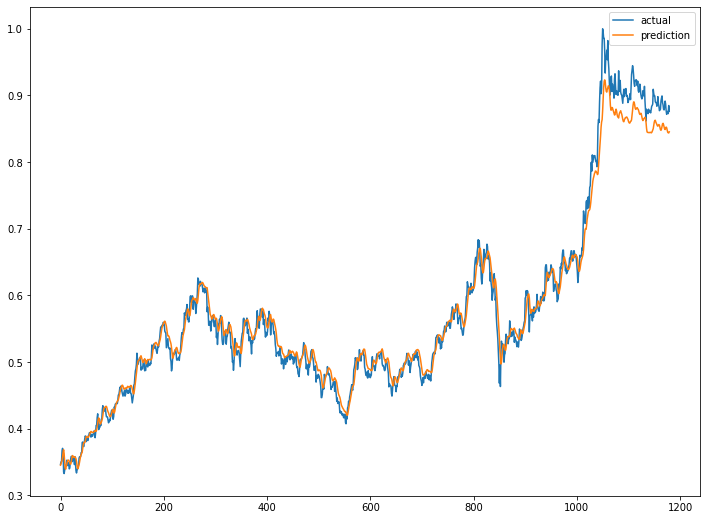

In [47]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()